## Lanaguage Identification with Linear Classification

### Checking If GPU is Enabled

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

### Importing libraries

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=d365f03b4a792f94c1996a18974e4de4cd1f972b3ecc6149ea895cb0440e2471
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import re
import emoji
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import pickle
from sklearn.model_selection import train_test_split
import re
import scipy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Loading Datasets as Dataframes

In [ ]:
def load_df(file_path):
    df = pd.read_csv(file_path, on_bad_lines="skip", sep = "\t")
    df = pd.DataFrame(np.vstack([df.columns, df]))
    df.rename(columns={0: "text", 1: "language"}, inplace=True)
    return df

In [ ]:
drive.mount('/content/drive')
train_df_path = "drive/My Drive/ML4NLP_assignment/exercise_1/train_dev_set+-+train_dev_set.csv"
test_df_path = "drive/My Drive/ML4NLP_assignment/exercise_1/test_set+-+test_set.csv"
train_df = load_df(train_df_path)
test_df = load_df(test_df_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train = train_df.text
y_train = train_df.language
X_test = test_df.text
y_test = test_df.language

#### Labeling y

In [ ]:
label_encoder = LabelEncoder()
full_y = np.append(y_train, y_test)
full_y = label_encoder.fit_transform(full_y)
y_train = full_y[:y_train.size]
y_test = full_y[y_train.size:]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
y_train = list(map(int, y_train))
y_val = list(map(int, y_val))
y_test = list(map(int, y_test))

### EDA

In [ ]:
train_df.head()

,text,language
0,@a7medmagdy11 كان قاعد معايا وقت الماتش و قال ...,ar
1,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
2,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
3,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
4,يا ابو سلو عرفتني,ar


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52676 entries, 0 to 52675
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      52676 non-null  object
 1   language  52676 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13280 entries, 0 to 13279
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      13280 non-null  object
 1   language  13280 non-null  object
dtypes: object(2)
memory usage: 207.6+ KB


In [ ]:
print("training dataset size: ", X_train.shape[0], " rows")
print("validation dataset size: ", X_val.shape[0], " rows")
print("testing dataset size: ", X_test.shape[0], " rows")

training dataset size:  47408  rows
validation dataset size:  5268  rows
testing dataset size:  13280  rows


In [ ]:
def color(val):
    color = "aquamarine" if type(val) == str else "white"
    return 'color: %s' % color

In [ ]:
data = {"train_language": y_train.value_counts().index.tolist()[:10], \
        "train_count": y_train.value_counts()[:10].tolist(), \
        "validation_language":  y_val.value_counts().index.tolist()[:10], \
        "validation_count": y_val.value_counts()[:10].tolist(), \
        "test_language":  y_test.value_counts().index.tolist()[:10], \
        "test_count": y_test.value_counts()[:10].tolist()}
df_count = pd.DataFrame.from_dict(data)
df_count.index = df_count.index + 1
df_count.style.applymap(color)

,train_language,train_count,validation_language,validation_count,test_language,test_count
1,en,16677,en,1831,en,4758
2,ja,9324,ja,1097,ja,2478
3,es,5369,es,561,es,1476
4,und,4085,und,452,und,1229
5,id,2685,id,321,id,818
6,pt,2593,pt,285,pt,699
7,ar,1987,ar,213,ar,529
8,ru,895,fr,89,ru,243
9,fr,857,ru,83,fr,224
10,tr,598,tr,71,tr,174


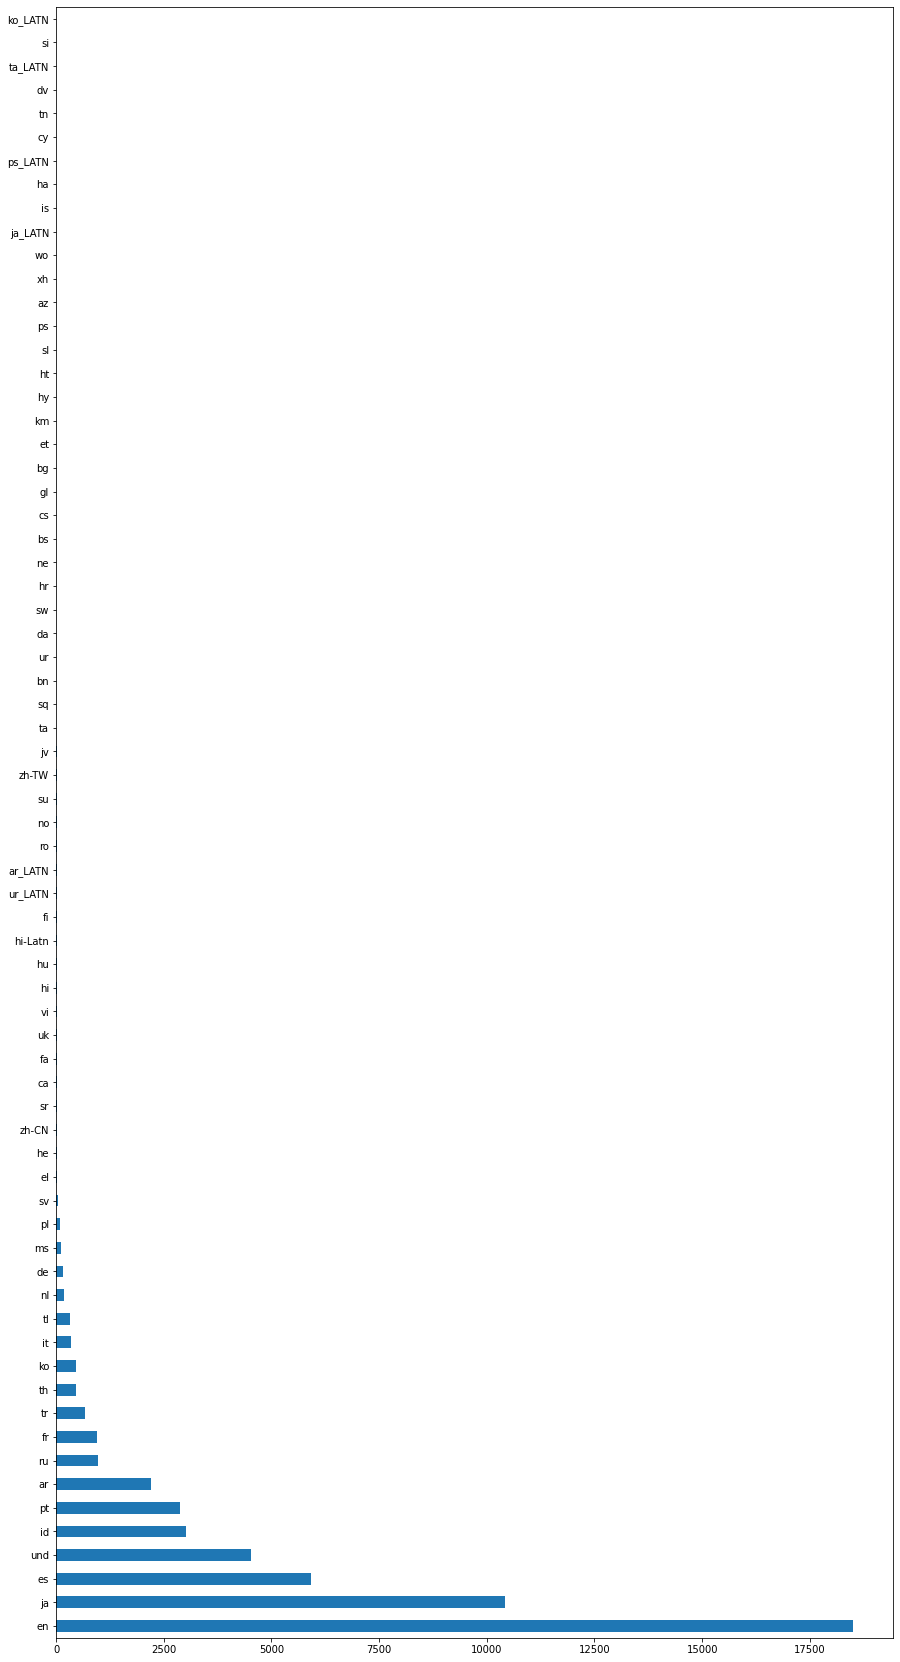

In [ ]:
y_train.value_counts().plot(kind="barh", figsize=(15, 30))

In [ ]:
def get_missing_class(train, compare):
    train_class = set(train.value_counts().index.tolist())
    compare_class = set(compare.value_counts().index.tolist())
    diff = list(compare_class - train_class)
    count = len([x for x in compare.tolist() if x in diff])
    # count = len(compare_df[compare_df["language"].isin(diff)])
    return list(diff), count

In [ ]:
print("These validation classes doesn't appear in training dataset:")
print(get_missing_class(y_train, y_val)[0])
print("The total counts are: ", get_missing_class(y_train, y_val)[1])

print("\nThese testing classes doesn't appear in training dataset:")
print(get_missing_class(y_train, y_test)[0])
print("The total counts are: ", get_missing_class(y_train, y_test)[1])

These validation classes doesn't appear in training dataset:
['ta_LATN', 'tn', 'dv', 'ht']
The total counts are:  5

These testing classes doesn't appear in training dataset:
['ht', 'mn', 'mk', 'sk', 'mr', 'yo', 'lv', 'eu', 'ta_LATN', 'la', 'zu']
The total counts are:  16


### Preprocessing

In [ ]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, purpose):
        self.purpose = purpose

    # LOWERCASING
    def convert_lowercase(self, text):
        text = text.str.lower()
        return text

    # REMOVING HTML TAGS AND URLS
    def remove_html_url(self, text):
        re_html = re.compile("<.*?>")
        re_url = re.compile("https?://\S+|www\.\S+")
        wo_html_str = re_html.sub(r"", text)
        wo_html_url_str = re_url.sub("", wo_html_str)
        return wo_html_url_str

    # REMOVING EMOJIS
    def remove_emoji(self, text):
        text = emoji.demojize(text)
        return text

    # LEMMATISATION
    def lemmatisation(self, text):
        lemmatiser = WordNetLemmatizer()
        return lemmatiser.lemmatize(text)

    def fit(self, X, y):
        return self

    def transform(self, X):
        res = X.apply(self.remove_html_url)
        res = res.apply(self.remove_emoji)
        if self.purpose == "preprocess":
            res = self.convert_lowercase(res)
            res = res.apply(self.lemmatisation)
        return res

In [ ]:
preprocess = Preprocessing("generate_extra_features")
X_train_extra_feature = preprocess.fit_transform(X_train, y_train)
X_val_extra_feature = preprocess.transform(X_val)
X_test_extra_feature = preprocess.transform(X_test)

### Defining Extra Features

#### Number of Spaces in A sentence

In [ ]:
def count_space(text):
    return text.count(" ")
X_train_num_space = X_train_extra_feature.apply(count_space)
X_val_num_space = X_val_extra_feature.apply(count_space)
X_test_num_space = X_test_extra_feature.apply(count_space)
X_num_space = [X_train_num_space, X_val_num_space, X_test_num_space]

#### Average Word Length

In [ ]:
def avg_word_len(text):
    text = re.sub(r"[^\w\s]", "", text)
    num_char = len(text) - text.count(" ")
    num_word = len(text.split())
    try:
        res = num_char/num_word
    except:
        res = 0
    return res
X_train_avg_word_len = X_train_extra_feature.apply(avg_word_len)
X_val_avg_word_len = X_val_extra_feature.apply(avg_word_len)
X_test_avg_word_len = X_test_extra_feature.apply(avg_word_len)
X_avg_word_len = [X_train_avg_word_len, X_val_avg_word_len, X_test_avg_word_len]

#### Number of Capitals in A Sentence

In [ ]:
def num_capital(text):
    return len(re.findall(r"[A-Z]", text))
X_train_num_capital = X_train_extra_feature.apply(num_capital)
X_val_num_capital = X_val_extra_feature.apply(num_capital)
X_test_num_capital = X_test_extra_feature.apply(num_capital)
X_num_capital = [X_train_num_capital, X_val_num_capital, X_test_num_capital]

In [ ]:
class ExtraFeature(BaseEstimator, TransformerMixin):
    def __init__(self, X_feature):
        self.X_feature = X_feature


    def fit(self, X, y):
        return self

    def transform(self, X):
        features = []
        if X.shape[0] == len(self.X_feature[0]):
            features.append(self.X_feature[0])
        elif X.shape[0] == len(self.X_feature[1]):
            features.append(self.X_feature[1])
        elif X.shape[0] == len(self.X_feature[2]):
            features.append(self.X_feature[2])
        return np.array(features).T
    
    # def get_feature_names_out(self):
    #     return np.array([self.feature_name])

### Model 1

In [ ]:
linear_clf = Pipeline([("Preprocessor", Preprocessing("preprocess")), \
                       ("countvect", CountVectorizer()), \
                       ("features", FeatureUnion([("tfidf", TfidfTransformer()), \
                                                  ("num_space", ExtraFeature(X_num_space)), \
                                                  ("avg_word_len", ExtraFeature(X_avg_word_len)), \
                                                  ("num_capital", ExtraFeature(X_num_capital))])), \
                       ("clf", LogisticRegression())])

In [ ]:
param_grid = {"clf__penalty": ["l2", "none"], \
              "clf__solver": ["newton-cg", "lbfgs", "liblinear"]}

model_1 = GridSearchCV(linear_clf, param_grid, cv=5, n_jobs=2, verbose=1)
model_1.fit(X_train, y_train)
pickle.dump(model_1, open("drive/My Drive/ML4NLP_assignment/exercise_1/model_1.sav", "wb"))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)

#### Testing on Validation Dataset

In [ ]:
loaded_model_1 = pickle.load(open("drive/My Drive/ML4NLP_assignment/exercise_1/model_1.sav", "rb"))
predict_1 = loaded_model_1.predict(X_val)

In [ ]:
correct = 0

for i, v in enumerate(list(predict_1)):
    if v == y_val[i]:
        correct += 1

print("Accuracy: ", correct/len(y_val))

Accuracy:  0.8170083523158694


### Model 2

In [ ]:
linear_clf = Pipeline([("Preprocessor", Preprocessing("preprocess")), \
                       ("countvect", CountVectorizer()), \
                       ("features", FeatureUnion([("tfidf", TfidfTransformer()), \
                                                  ("num_space", ExtraFeature(X_num_space)), \
                                                  ("avg_word_len", ExtraFeature(X_avg_word_len)), \
                                                  ("num_capital", ExtraFeature(X_num_capital))])), \
                       ("clf", LogisticRegression())])

In [ ]:
param_grid = {"clf__penalty": ["l2", "none"], \
              "clf__solver": ["newton-cg", "lbfgs", "liblinear"], \
              "countvect__analyzer": ["char"], \
              "countvect__ngram_range": [(1, 1), (2, 2), (3, 3)]}

model_2 = GridSearchCV(linear_clf, param_grid, cv=5, n_jobs=2, verbose=1)
model_2.fit(X_train, y_train)
pickle.dump(model_2, open("drive/My Drive/ML4NLP_assignment/exercise_1/model_2.sav", "wb"))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)

#### Testing on Valiadation Dataset

In [ ]:
loaded_model_2 = pickle.load(open("drive/My Drive/ML4NLP_assignment/exercise_1/model_2.sav", "rb"))
predict_2 = loaded_model_2.predict(X_val)

In [ ]:
correct = 0

for i, v in enumerate(list(predict_2)):
    if v == y_val[i]:
        correct += 1

print("Accuracy: ", correct/len(y_val))

Accuracy:  0.8225132877752468


#### Best Parameters

In [ ]:
loaded_model_2.best_params_

{'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'countvect__analyzer': 'char',
 'countvect__ngram_range': (1, 1)}

### Evaluation

#### Confusion Matrix

In [ ]:
y_train_predictions = loaded_model_2.predict(X_train).tolist()
print(precision_score(y_train, y_train_predictions, average='micro'))
print(recall_score(y_train, y_train_predictions, average='micro'))
print(f1_score(y_train, y_train_predictions, average='micro'))
conf_mx = confusion_matrix(y_train, y_train_predictions)
conf_mx

0.8337622342220722
0.8337622342220722
0.8337622342220722


array([[1947,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

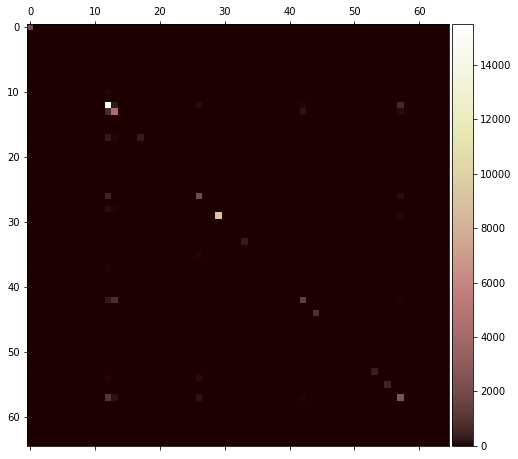

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.matshow(conf_mx, cmap="pink")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()

#### Normalised Confusion Matrix

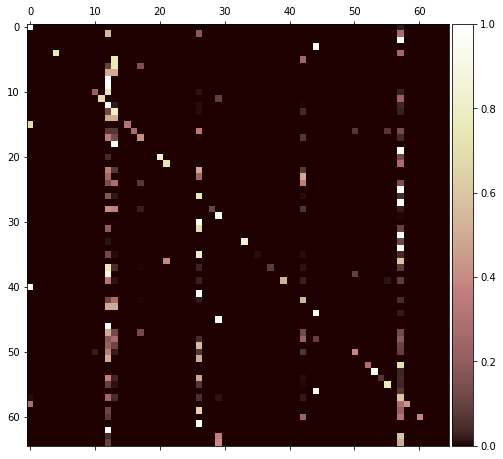

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

fig, ax = plt.subplots(figsize=(8,8))
im = ax.matshow(norm_conf_mx, cmap="pink")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()

#### Testing on Test Dataset

In [ ]:
loaded_model_2 = pickle.load(open("drive/My Drive/ML4NLP_assignment/exercise_1/model_2.sav", "rb"))
predict_2 = loaded_model_2.predict(X_test)

In [ ]:
correct = 0

for i, v in enumerate(list(predict_2)):
    if v == y_test[i]:
        correct += 1

print("Accuracy: ", correct/len(y_test))

Accuracy:  0.8248493975903615


### Feature Importance for All Languages

In [ ]:
X_train_preprocessed = scipy.sparse.load_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_train.npz")
X_val_preprocessed = scipy.sparse.load_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_val.npz")

In [ ]:
count_vect = Preprocessing("preprocess")
X_train_1 = count_vect.fit_transform(X_train, y_train)
X_val_1 = count_vect.transform(X_val)

In [ ]:
count_vect = CountVectorizer()
X_train_2 = count_vect.fit_transform(X_train_1)
X_val_2 = count_vect.transform(X_val_1)
X_test_2 = count_vect.transform(X_test_1)

In [ ]:
model = LogisticRegression(penalty="l2", solver="newton-cg")
model.fit(X_train_preprocessed, y_train)
importances = pd.DataFrame(data={
    "Feature": count_vect.get_feature_names_out().tolist() + ["num_space", "avg_word_len", "num_capital"],
    "Importance": model.coef_[0]
})
importances = importances.sort_values(by="Importance", ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


In [ ]:
importances

,Feature,Importance
92547,من,7.483227
86965,الله,7.121972
86968,اللهم,6.335905
91092,في,6.313764
90582,على,5.352073
...,...,...
49964,na,-1.383417
59220,que,-1.653329
41483,la,-1.815222
46356,me,-1.855033


In [ ]:
importances_extra = importances[(importances["Feature"]=="num_space") | \
                                (importances["Feature"]=="avg_word_len") | \
                                (importances["Feature"]=="num_capital")]
importances_extra

,Feature,Importance
119348,num_space,0.115511
119349,avg_word_len,0.113240
119350,num_capital,-0.292834


In [ ]:
importances.to_pickle("drive/My Drive/ML4NLP_assignment/exercise_1/importance.pkl")

### Feature Importance for EN, ES, JA

In [ ]:
X_train_preprocessed_part = scipy.sparse.load_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_train_part.npz")

In [ ]:
train_df = train_df[(train_df["language"]=="en") | (train_df["language"]=="es") | (train_df["language"]=="ja")]

In [ ]:
X_train = train_df.text
y_train = train_df.language
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
count_vect_part = Preprocessing("preprocess")
X_train_1_part = count_vect_part.fit_transform(X_train, y_train)
X_val_1_part = count_vect_part.transform(X_val)

In [ ]:
count_vect_part = CountVectorizer()
X_train_2_part = count_vect_part.fit_transform(X_train_1_part)
X_val_2_part = count_vect_part.transform(X_val_1_part)

In [ ]:
model_part = LogisticRegression(penalty="l2", solver="newton-cg")
model_part.fit(X_train_preprocessed_part, y_train)
importances_part = pd.DataFrame(data={
    'Feature': count_vect_part.get_feature_names_out().tolist() + ["num_space", "avg_word_len", "num_capital"],
    'Importance': model_part.coef_[0]
})
importances_part = importances_part.sort_values(by="Importance", ascending=False).reset_index(drop=True)

In [ ]:
importances_part.head(10)

,Feature,Importance
0,you,4.901267
1,the,4.573774
2,my,4.118720
3,to,4.049635
4,is,4.010862
5,and,3.826094
6,for,3.817267
7,in,3.775749
8,on,3.712783
9,it,3.693951


In [ ]:
importances_part_extra = importances_part[(importances_part["Feature"]=="num_space") | \
                                          (importances_part["Feature"]=="avg_word_len") | \
                                          (importances_part["Feature"]=="num_capital")]
importances_part_extra

,Feature,Importance
6800,num_space,0.074948
6914,num_capital,0.073081
51610,avg_word_len,-0.045019


In [ ]:
importances_part.to_pickle("drive/My Drive/ML4NLP_assignment/exercise_1/importance_part.pkl")

### Saving Preprocessed Data

In [ ]:
count_vect = Preprocessing("preprocess")
X_train_1 = count_vect.fit_transform(X_train, y_train)
X_val_1 = count_vect.transform(X_val)
X_test_1 = count_vect.transform(X_test)

In [ ]:
count_vect = CountVectorizer()
X_train_2 = count_vect.fit_transform(X_train_1)
X_val_2 = count_vect.transform(X_val_1)
X_test_2 = count_vect.transform(X_test_1)

In [ ]:
union = FeatureUnion([("tfidf", TfidfTransformer()), \
                    ("num_space", ExtraFeature(X_num_space)), \
                    ("avg_word_len", ExtraFeature(X_avg_word_len)), \
                    ("num_capital", ExtraFeature(X_num_capital))])
union_fit_train = union.fit_transform(X_train_2, y_train)
union_fit_val = union.transform(X_val_2)
union_fit_test = union.transform(X_test_2)

In [ ]:
scipy.sparse.save_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_train.npz", union_fit_train)
scipy.sparse.save_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_val.npz", union_fit_val)
scipy.sparse.save_npz("drive/My Drive/ML4NLP_assignment/exercise_1/X_test.npz", union_fit_test)